In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

In [34]:
from keras.layers import Input, LSTM, Dense, TimeDistributed
from keras import Model
from keras.metrics import AUC

In [8]:
df = pd.read_csv("./panel_wage.csv")

<AxesSubplot:ylabel='Density'>

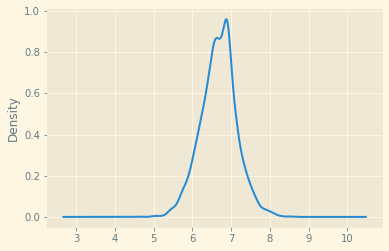

In [10]:
df["lwage"].plot(kind="density")

In [15]:
df["lwage_cat"] = pd.cut(df["lwage"], [0, 7, np.Inf], labels=[0, 1]).astype("int")

In [16]:
X = np.array([df.loc[:,"exp":"id"].groupby('id').get_group(i).values[:,:-2] for i in range(1, 596)])
Y = np.array([df.loc[:,["id","lwage_cat"]].groupby('id').get_group(i).values[:,1:] for i in range(1, 596)])

In [17]:
print(X.shape)
print(Y.shape)

(595, 7, 11)
(595, 7, 1)


In [18]:
input_layer = Input(shape=(7,11,))
encoder = LSTM(32, return_sequences=True)(input_layer)
decoder = LSTM(32, return_sequences=True)(encoder)
output = TimeDistributed(Dense(1, activation="sigmoid"))(decoder)
model = Model(inputs=input_layer, outputs=output)

2022-07-12 14:52:42.721907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
model.compile(optimizer="adam", loss="binary_crossentropy")

In [20]:
hist = model.fit(X, Y, batch_size=32, epochs=100, verbose=0)

In [21]:
Yh = model.predict(X)

19/19 [==============================] - 1s 2ms/step


In [22]:
print(Y[0].reshape((-1)))
print(Yh[0].reshape((-1)).round(3))

[0 0 0 0 0 0 0]
[0.002 0.001 0.005 0.008 0.015 0.055 0.125]


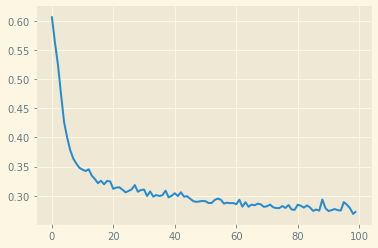

In [23]:
plt.plot(hist.history["loss"])

In [24]:
from panel_data_example import stratified_auc, auc_w

In [25]:
outcome_data = pd.DataFrame()
outcome_data["outcome"] = df["lwage_cat"]
outcome_data["p"] = Yh.reshape((-1))
outcome_data["count"] = df["t"]

In [52]:
temp = outcome_data.loc[outcome_data["count"] == 2]
temp.outcome.values.mean()

0.0

<AxesSubplot:ylabel='Frequency'>

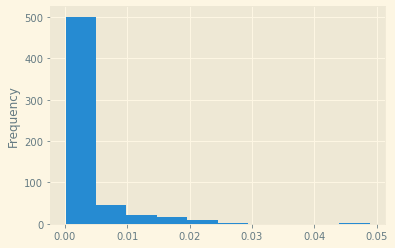

In [54]:
temp["p"].plot(kind="hist")

In [49]:
auc = AUC()
auc.update_state(temp.outcome.values, temp.p.values)
auc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [26]:
stratified_auc(outcome_data)

,auc_i,N_i
count,,
1,0.000000,595.0
2,0.000000,595.0
3,0.911034,595.0
4,0.909254,595.0
5,0.885374,595.0
6,0.862721,595.0
7,0.857558,595.0


In [27]:
auc_w(stratified_auc(outcome_data))

0.6322773098945618

In [1]:
from panel_data_example import train_generator

In [2]:
g = train_generator()

In [3]:
data = [next(g)[0] for _ in range(5)]

In [5]:
for elem in data:
	print(elem.shape)

(50, 97, 5)
(50, 99, 5)
(50, 11, 5)
(50, 31, 5)
(50, 37, 5)
